# Preprocessing and Modelling

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from prophet import Prophet
import cmdstanpy

## Load Data

In [6]:
data = pd.read_csv("../data/process/data.csv", index_col = 0)
data.index = pd.to_datetime(data.index)
data.head()

,Tesla,Nio,Rivian,Lucid Motors,Ford,General Motors,Interest Rate,CCI,Oil Prices,CPI
2021-11-10,355.983337,39.549999,100.730003,40.750000,15.992260,57.907940,0.163998,109.5,81.340,5.921978
2021-11-11,354.503326,42.200001,122.989998,44.980000,16.149208,60.399345,0.163998,109.5,81.590,5.921978
2021-11-12,344.473328,42.669998,129.949997,43.930000,16.107906,61.943035,0.163998,109.5,80.790,5.921978
2021-11-15,337.796661,40.570000,149.360001,44.880001,16.405281,61.522923,0.163998,109.5,80.880,5.921978
2021-11-16,351.576660,40.669998,172.009995,55.520000,16.347460,61.171192,0.163998,109.5,80.556,5.921978


In [7]:
data.tail()

,Tesla,Nio,Rivian,Lucid Motors,Ford,General Motors,Interest Rate,CCI,Oil Prices,CPI
2024-08-26,213.210007,4.03,14.36,4.26,11.11,48.628506,1.653358,103.3,77.15,3.052838
2024-08-27,209.210007,4.00,14.48,4.11,11.14,49.127258,1.653358,103.3,75.73,3.052838
2024-08-28,205.750000,3.70,13.83,3.94,11.04,48.927757,1.653358,103.3,74.38,3.052838
2024-08-29,206.279999,3.94,14.09,3.96,11.11,49.346714,1.653358,103.3,75.76,3.052838
2024-08-30,214.110001,4.04,14.13,4.02,11.19,49.655937,1.653358,103.3,73.65,3.052838


## Preprocessing

### Check for missing values

In [8]:
data.isna().sum()

Tesla             0
Nio               0
Rivian            0
Lucid Motors      0
Ford              0
General Motors    0
Interest Rate     0
CCI               0
Oil Prices        0
CPI               0
dtype: int64

## Feature Engineering

### Date Features

In [9]:
data["month"] = data.index.month
data["day"] = data.index.day
data["weekday"] = data.index.weekday + 1
data["year"] = data.index.year

### Lag Features

In [10]:
data["Date"] = data.index
data = data.reset_index(drop = True)
lag_features = ["Tesla", "Nio", "Rivian", "Lucid Motors", "Ford", "General Motors", "Interest Rate", "CCI", "Oil Prices", "CPI"]
window1 = 1
window2 = 4
window3 = 30

data_rolled_1 = data[lag_features].rolling(window = window1, min_periods = 0)
data_rolled_4 = data[lag_features].rolling(window = window2, min_periods = 0)
data_rolled_30 = data[lag_features].rolling(window = window3, min_periods = 0)

data_mean_1 = data_rolled_1.mean().shift(1).reset_index().astype(np.float32)
data_mean_4 = data_rolled_4.mean().shift(1).reset_index().astype(np.float32)
data_mean_30 = data_rolled_30.mean().shift(1).reset_index().astype(np.float32)

data_std_4 = data_rolled_4.std().shift(1).reset_index().astype(np.float32)
data_std_30 = data_rolled_30.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    data[f"{feature}_mean_lag{window1}"] = data_mean_1[feature]
    data[f"{feature}_mean_lag{window2}"] = data_mean_4[feature]
    data[f"{feature}_mean_lag{window3}"] = data_mean_30[feature]

    data[f"{feature}_std_lag{window2}"] = data_std_4[feature]
    data[f"{feature}_std_lag{window3}"] = data_std_30[feature]

data.fillna(data.mean(), inplace = True)

data.set_index("Date", drop = True, inplace = True)

data.head()

,Tesla,Nio,Rivian,Lucid Motors,Ford,General Motors,Interest Rate,CCI,Oil Prices,CPI,...,Oil Prices_mean_lag1,Oil Prices_mean_lag4,Oil Prices_mean_lag30,Oil Prices_std_lag4,Oil Prices_std_lag30,CPI_mean_lag1,CPI_mean_lag4,CPI_mean_lag30,CPI_std_lag4,CPI_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-10,355.983337,39.549999,100.730003,40.750000,15.992260,57.907940,0.163998,109.5,81.340,5.921978,...,83.638237,83.651176,83.699051,1.646993,3.832741,5.420475,5.426588,5.476696,0.080124,0.537944
2021-11-11,354.503326,42.200001,122.989998,44.980000,16.149208,60.399345,0.163998,109.5,81.590,5.921978,...,81.339996,81.339996,81.339996,1.646993,3.832741,5.921978,5.921978,5.921978,0.080124,0.537944
2021-11-12,344.473328,42.669998,129.949997,43.930000,16.107906,61.943035,0.163998,109.5,80.790,5.921978,...,81.589996,81.464996,81.464996,0.176777,0.176777,5.921978,5.921978,5.921978,0.000000,0.000000
2021-11-15,337.796661,40.570000,149.360001,44.880001,16.405281,61.522923,0.163998,109.5,80.880,5.921978,...,80.790001,81.239998,81.239998,0.409268,0.409268,5.921978,5.921978,5.921978,0.000000,0.000000
2021-11-16,351.576660,40.669998,172.009995,55.520000,16.347460,61.171192,0.163998,109.5,80.556,5.921978,...,80.879997,81.150002,81.150002,0.379561,0.379561,5.921978,5.921978,5.921978,0.000000,0.000000


### Set index frequency to daily

In [11]:
data = data.asfreq(pd.infer_freq(data.index))
data = data.ffill()

### Split the data in train and test sets

In [12]:
split_size = int(len(data) * 0.8)
train = data.iloc[:split_size]
test = data.iloc[split_size:]

## Modelling

### Tesla ARIMA Model

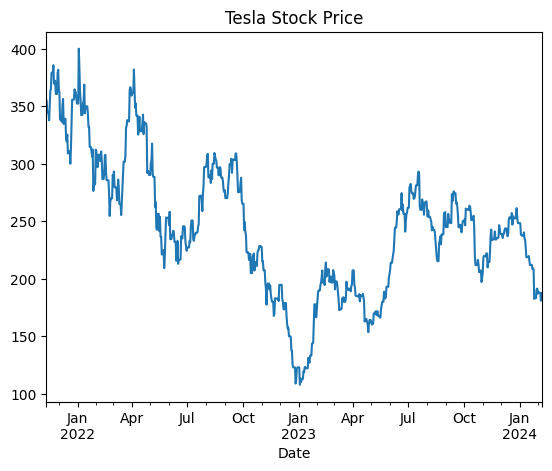

In [13]:
train["Tesla"].plot()
plt.title("Tesla Stock Price")
plt.show()

Test for Stationarity

In [14]:
tesla_adft = adfuller(train["Tesla"])
print(f"Test Statistic: {tesla_adft[0]}")
print(f"p-value: {tesla_adft[1]}")
if tesla_adft[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

Test Statistic: -2.406768650874843
p-value: 0.13983511355262485
The time series is not stationary.


Autocorrelation Function (AFC) Plot

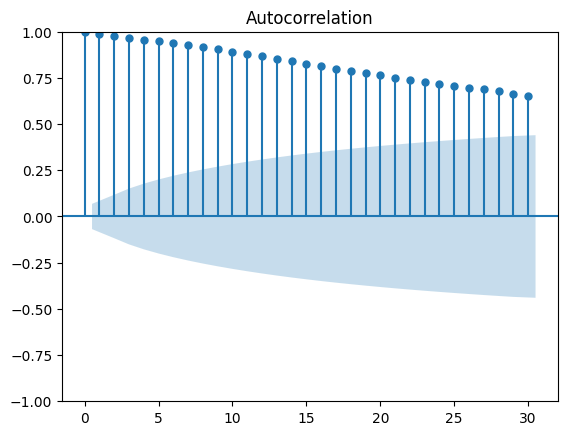

In [15]:
plot_acf(train["Tesla"])
plt.show()

Autocorrelation Function (AFC) Plot

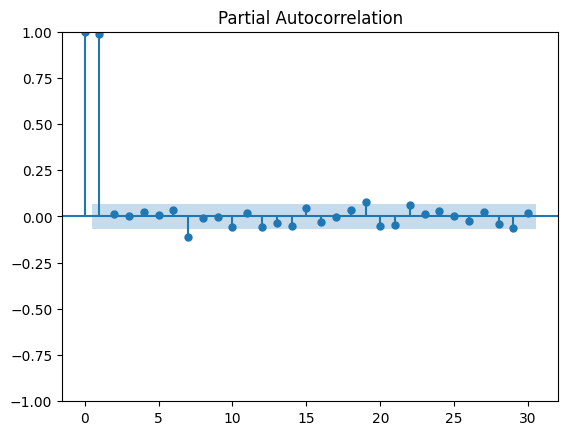

In [16]:
plot_pacf(train["Tesla"])
plt.show()

In [17]:
tesla_pmdarima = auto_arima(train["Tesla"],
                            seasonal = True,
                            trace = True,
                            error_action = "ignore",
                            stepwise = True
                            )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5695.272, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5696.624, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5696.631, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5693.839, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5697.478, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.819 seconds


In [18]:
tesla_pmdarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  820
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2845.920
Date:                Sun, 08 Sep 2024   AIC                           5693.839
Time:                        13:25:21   BIC                           5698.548
Sample:                    11-10-2021   HQIC                          5695.646
                         - 02-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        61.0625      1.682     36.294      0.000      57.765      64.360
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               671.14
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto ARIMA results indicate that the best model is:  
1. ARIMA(0,1,0)(0,0,0)[0] / AIC = 5693.839  
2. ARIMA(1,1,0)(0,0,0)[0] / AIC = 5696.624  
3. ARIMA(0,1,1)(0,0,0)[0] / AIC = 5696.631
4. ARIMA(1,1,1)(0,0,0)[0] / AIC = 5697.478    

The difference between the evaluation metric of these four models is very short. It is not possible to say that the first model is significantly better.

### Find the best parameters for the ARIMA model

Time Series Split

In [19]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits = n_splits)

ARIMA Model 1

In [20]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (0, 1, 0))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arima1 =  np.mean(mae_scores)
avg_rmse_arima1 = np.mean(rmse_scores)
avg_aic_arima1 = np.mean(aic_scores)
avg_bic_arima1 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arima1:.4f}')
print(f'Average RMSE: {avg_rmse_arima1:.4f}')
print(f'Average AIC: {avg_aic_arima1:.4f}')
print(f'Average BIC: {avg_bic_arima1:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 42.6041, RMSE: 50.6082, AIC: 1563.3632, BIC: 1566.6814
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 69.5903, RMSE: 81.6534, AIC: 2993.5914, BIC: 2997.6051
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 52.5925, RMSE: 57.2586, AIC: 4346.8568, BIC: 4351.2768
---
Average MAE: 54.9290
Average RMSE: 63.1734
Average AIC: 2967.9371
Average BIC: 2971.8544


ARIMA Model 2

In [21]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (1, 1, 0))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arima2 =  np.mean(mae_scores)
avg_rmse_arima2 = np.mean(rmse_scores)
avg_aic_arima2 = np.mean(aic_scores)
avg_bic_arima2 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arima2:.4f}')
print(f'Average RMSE: {avg_rmse_arima2:.4f}')
print(f'Average AIC: {avg_aic_arima2:.4f}')
print(f'Average BIC: {avg_bic_arima2:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 42.4680, RMSE: 50.4090, AIC: 1564.9632, BIC: 1571.5994
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 69.5903, RMSE: 81.6534, AIC: 2994.6793, BIC: 3002.7067
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 52.2328, RMSE: 56.9220, AIC: 4347.7463, BIC: 4356.5862
---
Average MAE: 54.7637
Average RMSE: 62.9948
Average AIC: 2969.1296
Average BIC: 2976.9641


ARIMA Model 3

In [22]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (0, 1, 1))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arima3 =  np.mean(mae_scores)
avg_rmse_arima3 = np.mean(rmse_scores)
avg_aic_arima3 = np.mean(aic_scores)
avg_bic_arima3 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arima3:.4f}')
print(f'Average RMSE: {avg_rmse_arima3:.4f}')
print(f'Average AIC: {avg_aic_arima3:.4f}')
print(f'Average BIC: {avg_bic_arima3:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 42.4558, RMSE: 50.3913, AIC: 1564.9357, BIC: 1571.5719
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 69.5852, RMSE: 81.6482, AIC: 2994.6805, BIC: 3002.7079
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 52.2213, RMSE: 56.9113, AIC: 4347.7590, BIC: 4356.5990
---
Average MAE: 54.7541
Average RMSE: 62.9836
Average AIC: 2969.1251
Average BIC: 2976.9596


ARIMA Model 4

In [23]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (1, 1, 1))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arima4 =  np.mean(mae_scores)
avg_rmse_arima4 = np.mean(rmse_scores)
avg_aic_arima4 = np.mean(aic_scores)
avg_bic_arima4 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arima4:.4f}')
print(f'Average RMSE: {avg_rmse_arima4:.4f}')
print(f'Average AIC: {avg_aic_arima4:.4f}')
print(f'Average BIC: {avg_bic_arima4:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 42.2315, RMSE: 50.0619, AIC: 1566.4266, BIC: 1576.3809
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 69.5916, RMSE: 81.6546, AIC: 2996.6789, BIC: 3008.7201
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 52.4035, RMSE: 57.0817, AIC: 4349.1189, BIC: 4362.3789
---
Average MAE: 54.7422
Average RMSE: 62.9328
Average AIC: 2970.7415
Average BIC: 2982.4933


ARIMA Models Summary

In [24]:
MAE_values = [avg_mae_arima1, avg_mae_arima2, avg_mae_arima3, avg_mae_arima4]
RMSE_vales = [avg_rmse_arima1, avg_rmse_arima2, avg_rmse_arima3, avg_rmse_arima4]
AIC_values = [avg_aic_arima1, avg_aic_arima2, avg_aic_arima3, avg_aic_arima4]
BIC_values = [avg_bic_arima1, avg_bic_arima2, avg_bic_arima3, avg_bic_arima4]

In [25]:
arima_summary = pd.DataFrame(data = [MAE_values, RMSE_vales, AIC_values, BIC_values], index = ["MAE", "RMSE", "AIC", "BIC"], 
                             columns = ["ARIMA(0,1,0)", "ARIMA(1,1,0)", "ARIMA(0,1,1)", "ARIMA(1,1,1)"])
arima_summary

,"ARIMA(0,1,0)","ARIMA(1,1,0)","ARIMA(0,1,1)","ARIMA(1,1,1)"
MAE,54.928999,54.763690,54.754103,54.742209
RMSE,63.173388,62.994787,62.983607,62.932761
AIC,2967.937139,2969.129569,2969.125052,2970.741464
BIC,2971.854416,2976.964122,2976.959605,2982.493294


### Auto ARIMA + Exogenous Variables

In [26]:
data.columns

Index(['Tesla', 'Nio', 'Rivian', 'Lucid Motors', 'Ford', 'General Motors',
       'Interest Rate', 'CCI', 'Oil Prices', 'CPI', 'month', 'day', 'weekday',
       'year', 'Tesla_mean_lag1', 'Tesla_mean_lag4', 'Tesla_mean_lag30',
       'Tesla_std_lag4', 'Tesla_std_lag30', 'Nio_mean_lag1', 'Nio_mean_lag4',
       'Nio_mean_lag30', 'Nio_std_lag4', 'Nio_std_lag30', 'Rivian_mean_lag1',
       'Rivian_mean_lag4', 'Rivian_mean_lag30', 'Rivian_std_lag4',
       'Rivian_std_lag30', 'Lucid Motors_mean_lag1', 'Lucid Motors_mean_lag4',
       'Lucid Motors_mean_lag30', 'Lucid Motors_std_lag4',
       'Lucid Motors_std_lag30', 'Ford_mean_lag1', 'Ford_mean_lag4',
       'Ford_mean_lag30', 'Ford_std_lag4', 'Ford_std_lag30',
       'General Motors_mean_lag1', 'General Motors_mean_lag4',
       'General Motors_mean_lag30', 'General Motors_std_lag4',
       'General Motors_std_lag30', 'Interest Rate_mean_lag1',
       'Interest Rate_mean_lag4', 'Interest Rate_mean_lag30',
       'Interest Rate_std_lag4',

Exogeneous Variables

ARIMAX model 1

In [27]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (0, 1, 0), exog = train_data.drop(columns = ["Tesla"]))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data), exog = val_data.drop(columns = ["Tesla"]))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arimax1 =  np.mean(mae_scores)
avg_rmse_arimax1 = np.mean(rmse_scores)
avg_aic_arimax1 = np.mean(aic_scores)
avg_bic_arimax1 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arimax1:.4f}')
print(f'Average RMSE: {avg_rmse_arimax1:.4f}')
print(f'Average AIC: {avg_aic_arimax1:.4f}')
print(f'Average BIC: {avg_bic_arimax1:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 382.9954, RMSE: 409.9307, AIC: 1422.4566, BIC: 1634.8162
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 40.6681, RMSE: 49.9681, AIC: 2724.4990, BIC: 2981.3768
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 23.3063, RMSE: 26.5709, AIC: 4006.9338, BIC: 4289.8135
---
Average MAE: 148.9900
Average RMSE: 162.1566
Average AIC: 2717.9631
Average BIC: 2968.6689


ARIMAX model 2

In [28]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (1, 1, 0), exog = train_data.drop(columns = ["Tesla"]))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data), exog = val_data.drop(columns = ["Tesla"]))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arimax2 =  np.mean(mae_scores)
avg_rmse_arimax2 = np.mean(rmse_scores)
avg_aic_arimax2 = np.mean(aic_scores)
avg_bic_arimax2 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arimax2:.4f}')
print(f'Average RMSE: {avg_rmse_arimax2:.4f}')
print(f'Average AIC: {avg_aic_arimax2:.4f}')
print(f'Average BIC: {avg_bic_arimax2:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 392.2137, RMSE: 419.4093, AIC: 1419.7668, BIC: 1635.4446
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 41.2388, RMSE: 50.7175, AIC: 2726.0594, BIC: 2986.9509
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 21.8879, RMSE: 24.8541, AIC: 4006.6780, BIC: 4293.9777
---
Average MAE: 151.7801
Average RMSE: 164.9936
Average AIC: 2717.5014
Average BIC: 2972.1244


ARIMAX model 3

In [29]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (0, 1, 1), exog = train_data.drop(columns = ["Tesla"]))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data), exog = val_data.drop(columns = ["Tesla"]))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arimax3 =  np.mean(mae_scores)
avg_rmse_arimax3 = np.mean(rmse_scores)
avg_aic_arimax3 = np.mean(aic_scores)
avg_bic_arimax3 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arimax3:.4f}')
print(f'Average RMSE: {avg_rmse_arimax3:.4f}')
print(f'Average AIC: {avg_aic_arimax3:.4f}')
print(f'Average BIC: {avg_bic_arimax3:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 392.2312, RMSE: 419.6434, AIC: 1418.8097, BIC: 1634.4875
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 41.0861, RMSE: 50.5495, AIC: 2726.1984, BIC: 2987.0898
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 22.2957, RMSE: 25.3392, AIC: 4007.4181, BIC: 4294.7178
---
Average MAE: 151.8710
Average RMSE: 165.1773
Average AIC: 2717.4754
Average BIC: 2972.0984


ARIMAX model 4

In [30]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []
aic_scores = []
bic_scores = []

# Loop through the splits
for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Fit ARIMA model on train data
    model = ARIMA(train_data['Tesla'], order = (1, 1, 1), exog = train_data.drop(columns = ["Tesla"]))  
    model_fit = model.fit()

    # Forecast using the trained model for the test set
    forecast = model_fit.forecast(steps=len(val_data), exog = val_data.drop(columns = ["Tesla"]))

    # Calculate evaluation metrics
    mae = mean_absolute_error(val_data['Tesla'].values, forecast)
    rmse = np.sqrt(mean_squared_error(val_data['Tesla'].values, forecast))
    
    # Append AIC and BIC from model fit
    aic = model_fit.aic
    bic = model_fit.bic

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, AIC: {aic:.4f}, BIC: {bic:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_arimax4 =  np.mean(mae_scores)
avg_rmse_arimax4 = np.mean(rmse_scores)
avg_aic_arimax4 = np.mean(aic_scores)
avg_bic_arimax4 = np.mean(bic_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_arimax4:.4f}')
print(f'Average RMSE: {avg_rmse_arimax4:.4f}')
print(f'Average AIC: {avg_aic_arimax4:.4f}')
print(f'Average BIC: {avg_bic_arimax4:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 392.1177, RMSE: 419.6140, AIC: 1420.7953, BIC: 1639.7913
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 40.5609, RMSE: 49.9677, AIC: 2726.9101, BIC: 2991.8153
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 22.0141, RMSE: 24.9813, AIC: 4007.5678, BIC: 4299.2875
---
Average MAE: 151.5643
Average RMSE: 164.8544
Average AIC: 2718.4244
Average BIC: 2976.9647


ARIMAX Models Summary

In [31]:
MAE_values2 = [avg_mae_arimax1, avg_mae_arimax2, avg_mae_arimax3, avg_mae_arimax4]
RMSE_vales2 = [avg_rmse_arimax1, avg_rmse_arimax2, avg_rmse_arimax3, avg_rmse_arimax4]
AIC_values2 = [avg_aic_arimax1, avg_aic_arimax2, avg_aic_arimax3, avg_aic_arimax4]
BIC_values2 = [avg_bic_arimax1, avg_bic_arimax2, avg_bic_arimax3, avg_bic_arimax4]

In [32]:
arimax_summary = pd.DataFrame(data = [MAE_values2, RMSE_vales2, AIC_values2, BIC_values2], index = ["MAE", "RMSE", "AIC", "BIC"], 
                             columns = ["ARIMAX(0,1,0)", "ARIMAX(1,1,0)", "ARIMAX(0,1,1)", "ARIMAX(1,1,1)"])
arimax_summary

,"ARIMAX(0,1,0)","ARIMAX(1,1,0)","ARIMAX(0,1,1)","ARIMAX(1,1,1)"
MAE,148.989954,151.780150,151.871022,151.564256
RMSE,162.156566,164.993619,165.177348,164.854365
AIC,2717.963147,2717.501396,2717.475376,2718.424425
BIC,2968.668855,2972.124381,2972.098361,2976.964687


### ML Approach

In [33]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Prepare features and target
    X_train = train_data.drop(columns='Tesla')
    y_train = train_data['Tesla']
    X_val = val_data.drop(columns='Tesla')
    y_val = val_data['Tesla']

    # Fit the Linear Regression model
    model = LinearRegression()
    model_fit = model.fit(X_train, y_train)

    # Forecast using the trained model for the validation set
    predictions = model_fit.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_linear = np.mean(mae_scores)
avg_rmse_linear = np.mean(rmse_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_linear:.4f}')
print(f'Average RMSE: {avg_rmse_linear:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 516.7543, RMSE: 558.9326
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 48.0979, RMSE: 61.7602
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 15.3077, RMSE: 18.1512
---
Average MAE: 193.3866
Average RMSE: 212.9480


In [34]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Prepare features and target
    X_train = train_data.drop(columns='Tesla')
    y_train = train_data['Tesla']
    X_val = val_data.drop(columns='Tesla')
    y_val = val_data['Tesla']

    # Fit the Linear Regression model
    model = Ridge()
    model_fit = model.fit(X_train, y_train)

    # Forecast using the trained model for the validation set
    predictions = model_fit.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_ridge = np.mean(mae_scores)
avg_rmse_ridge = np.mean(rmse_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_ridge:.4f}')
print(f'Average RMSE: {avg_rmse_ridge:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 47.1389, RMSE: 57.9150
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 14.5103, RMSE: 16.7279
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 7.8418, RMSE: 10.2845
---
Average MAE: 23.1637
Average RMSE: 28.3092


In [35]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Prepare features and target
    X_train = train_data.drop(columns='Tesla')
    y_train = train_data['Tesla']
    X_val = val_data.drop(columns='Tesla')
    y_val = val_data['Tesla']

    # Fit the Linear Regression model
    model = Lasso()
    model_fit = model.fit(X_train, y_train)

    # Forecast using the trained model for the validation set
    predictions = model_fit.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_lasso = np.mean(mae_scores)
avg_rmse_lasso = np.mean(rmse_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_lasso:.4f}')
print(f'Average RMSE: {avg_rmse_lasso:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 8.8905, RMSE: 11.3324
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 5.7464, RMSE: 7.4436
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 4.5930, RMSE: 6.3889
---
Average MAE: 6.4100
Average RMSE: 8.3883


In [36]:
# Lists to store metrics for each fold
mae_scores = []
rmse_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]

    # Prepare features and target
    X_train = train_data.drop(columns='Tesla')
    y_train = train_data['Tesla']
    X_val = val_data.drop(columns='Tesla')
    y_val = val_data['Tesla']

    # Fit the Linear Regression model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, max_depth=3)
    model_fit = model.fit(X_train, y_train)

    # Forecast using the trained model for the validation set
    predictions = model_fit.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))

    # Store the metrics for each fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Output results for this fold
    print(f'Fold {fold + 1}')
    print(f'Training set size: {len(train_data)}, Validation set size: {len(val_data)}')
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    print('---')

# Save evaluation metrics of the model
avg_mae_xgb = np.mean(mae_scores)
avg_rmse_xgb = np.mean(rmse_scores)

# Output the average performance across all folds
print(f'Average MAE: {avg_mae_xgb:.4f}')
print(f'Average RMSE: {avg_rmse_xgb:.4f}')

Fold 1
Training set size: 205, Validation set size: 205
MAE: 37.0427, RMSE: 53.3574
---
Fold 2
Training set size: 410, Validation set size: 205
MAE: 27.8585, RMSE: 32.5833
---
Fold 3
Training set size: 615, Validation set size: 205
MAE: 14.4116, RMSE: 16.2319
---
Average MAE: 26.4376
Average RMSE: 34.0575


### ML models summary

In [37]:
MAE_values3 = [avg_mae_linear, avg_mae_ridge, avg_mae_lasso, avg_mae_xgb]
RMSE_vales3 = [avg_rmse_linear, avg_rmse_ridge, avg_rmse_lasso, avg_rmse_xgb]

In [38]:
ml_summary = pd.DataFrame(data = [MAE_values3, RMSE_vales3], index = ["MAE", "RMSE"], 
                             columns = ["Linear Regression", "Ridge", "Lasso", "XGB"])
ml_summary

,Linear Regression,Ridge,Lasso,XGB
MAE,193.386642,23.163696,6.409952,26.437577
RMSE,212.948027,28.309152,8.388306,34.057540


### Final Summary

In [39]:
final_summary = pd.concat([arima_summary, arimax_summary, ml_summary], axis = 1)

In [40]:
final_summary_T = round(final_summary.T, 2)

In [41]:
final_summary_T

,MAE,RMSE,AIC,BIC
"ARIMA(0,1,0)",54.93,63.17,2967.94,2971.85
"ARIMA(1,1,0)",54.76,62.99,2969.13,2976.96
"ARIMA(0,1,1)",54.75,62.98,2969.13,2976.96
"ARIMA(1,1,1)",54.74,62.93,2970.74,2982.49
"ARIMAX(0,1,0)",148.99,162.16,2717.96,2968.67
"ARIMAX(1,1,0)",151.78,164.99,2717.50,2972.12
"ARIMAX(0,1,1)",151.87,165.18,2717.48,2972.10
"ARIMAX(1,1,1)",151.56,164.85,2718.42,2976.96
Linear Regression,193.39,212.95,NaN,NaN
Ridge,23.16,28.31,NaN,NaN


## Test Data

### Deciding which ARIMA model is the best

In [42]:
final_arima1 = ARIMA(train["Tesla"], order = (1,1,1))
final_arima1_fit = final_arima1.fit()
forecast_fa1 = final_arima1_fit.forecast(steps = len(test))

In [43]:
final_arima2 = ARIMA(train["Tesla"], order = (0,1,0))
final_arima2_fit = final_arima2.fit()
forecast_fa2 = final_arima1_fit.forecast(steps = len(test))

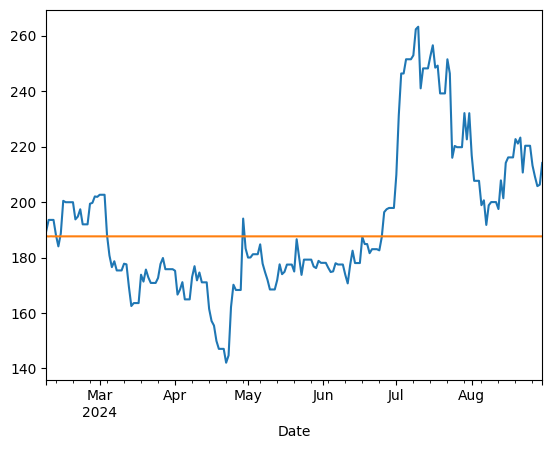

In [44]:
test["Tesla"].plot()
forecast_fa1.plot()
plt.show()

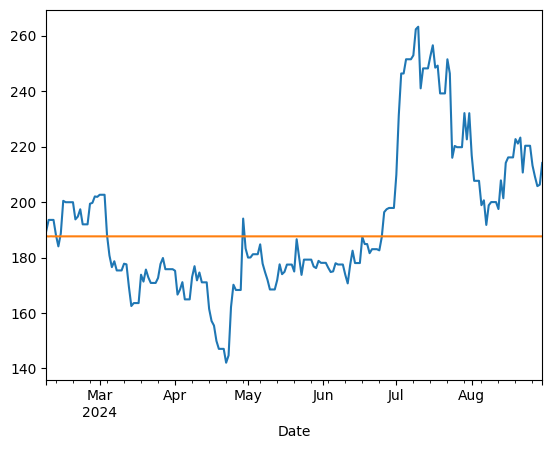

In [45]:
test["Tesla"].plot()
forecast_fa2.plot()
plt.show()

### Lasso Model

In [46]:
lasso_final = Lasso()
lasso_final.fit(train.drop(columns = ["Tesla"]), train["Tesla"])
preds_lasso_final = lasso_final.predict(test.drop(columns = "Tesla"))

In [47]:
preds_lasso_final = pd.Series(preds_lasso_final, index = test.index)

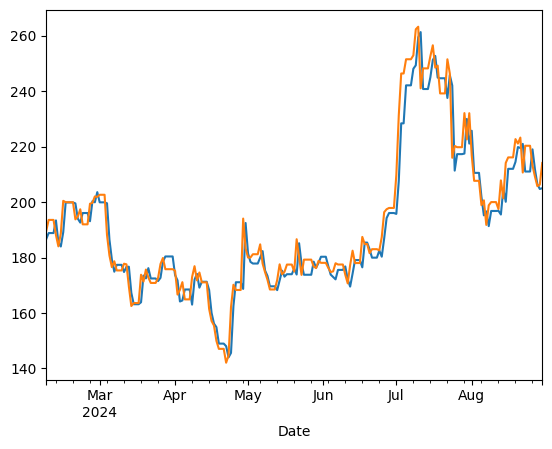

In [48]:
preds_lasso_final.plot()
test["Tesla"].plot()
plt.show()

### Hybrid Model Composition

In [49]:
preds_lasso_final

Date
2024-02-08    186.645328
2024-02-09    188.824892
2024-02-10    188.824892
2024-02-11    188.824892
2024-02-12    193.390166
                 ...    
2024-08-26    219.018700
2024-08-27    211.849855
2024-08-28    206.459695
2024-08-29    204.723586
2024-08-30    205.004729
Freq: D, Length: 205, dtype: float64

In [50]:
forecast_fa1

2024-02-08    187.676739
2024-02-09    187.602489
2024-02-10    187.659479
2024-02-11    187.615737
2024-02-12    187.649311
                 ...    
2024-08-26    187.634732
2024-08-27    187.634732
2024-08-28    187.634732
2024-08-29    187.634732
2024-08-30    187.634732
Freq: D, Name: predicted_mean, Length: 205, dtype: float64

In [51]:
test["Tesla"]

Date
2024-02-08    189.559998
2024-02-09    193.570007
2024-02-10    193.570007
2024-02-11    193.570007
2024-02-12    188.130005
                 ...    
2024-08-26    213.210007
2024-08-27    209.210007
2024-08-28    205.750000
2024-08-29    206.279999
2024-08-30    214.110001
Freq: D, Name: Tesla, Length: 205, dtype: float64

In [52]:
# Initialize variables to keep track of the best result
best_mae = float('inf')
best_weight_lasso = 0
best_weight_arima = 0

# Iterate over possible weight combinations
for weight_lasso in np.linspace(0, 1, 100):  # 0 to 1 with 100 steps
    weight_arima = 1 - weight_lasso
    hybrid_forecasts = weight_lasso * preds_lasso_final + weight_arima * forecast_fa1
    mae = mean_absolute_error(test["Tesla"], hybrid_forecasts)
    
    # Update the best result if current MAE is lower
    if mae < best_mae:
        best_mae = mae
        best_weight_lasso = weight_lasso
        best_weight_arima = weight_arima

# Output the best weights and corresponding MAE
print(f'Best MAE: {best_mae:.4f}')
print(f'Best Weight for Lasso: {best_weight_lasso:.4f}')
print(f'Best Weight for ARIMA: {best_weight_arima:.4f}')

Best MAE: 4.7464
Best Weight for Lasso: 1.0000
Best Weight for ARIMA: 0.0000


The best model composition does not include ARIMA model at all. So, the final selected model is Lasso.

## Final Model

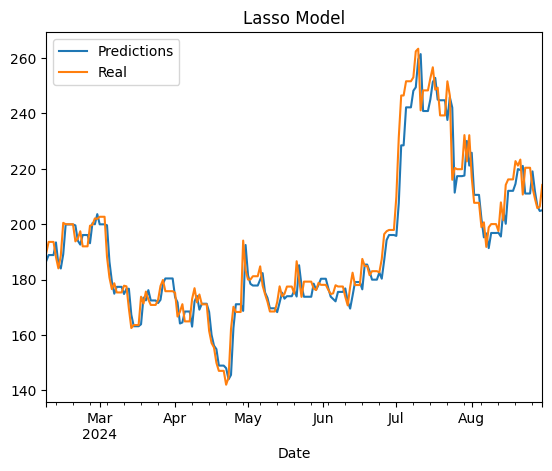

In [53]:
preds_lasso_final.plot()
test["Tesla"].plot()
plt.title("Lasso Model")
plt.legend(["Predictions", "Real"])
plt.show()